# Install Dependencies

In [3]:
!pip install tensorflow==2.4.1 opencv-python matplotlib

  Using cached tensorflow-2.4.1-cp38-cp38-macosx_10_11_x86_64.whl (173.9 MB)
     |████████████████████████████████| 45.9 MB 5.0 MB/s eta 0:00:01
     |████████████████████████████████| 15.6 MB 21 kB/s  eta 0:00:01
     |████████████████████████████████| 65 kB 3.7 MB/s eta 0:00:01
     |████████████████████████████████| 132 kB 5.0 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 1.3 MB/s eta 0:00:011
     |████████████████████████████████| 3.3 MB 4.8 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 5.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 4.2 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 6.8 MB/s  eta 0:00:01
     |████████████████████████████████| 5.8 MB 6.2 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 3.5 MB 5.9 MB/s eta 0:00:01
     |████████████████████████████████| 781 kB 5.4 MB/s eta 0:00:01
     |████████████████████████████████|

# Import Dependencies

In [10]:
# Standard
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
# TF Functional API Imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense,MaxPooling2D,Input,Flatten
import tensorflow as tf


# GPU Growth

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

# Folder Paths

In [6]:
POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data','negative')
ANC_PATH = os.path.join('data','anchor')

In [7]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# LFW Dataset

In [14]:
!tar -xf lfw.tgz

In [15]:
for directory in os.listdir('lfw'):
  for file in os.listdir(os.path.join('lfw',directory)):
      CURRENT_PATH = os.path.join('lfw',directory,file)
      NEW_PATH = os.path.join(NEG_PATH,file)
      os.replace(CURRENT_PATH,NEW_PATH)

# Getting Data for Anchors and Positive Classes

In [40]:
import uuid

In [43]:
capture_device = cv2.VideoCapture(0)
while capture_device.isOpened():
    ret, frame = capture_device.read()
    #Making image 250px x 250px
    frame = frame[250:250+250,550:550+250,:]
    #Collecting Anchors
    if cv2.waitKey(1) & 0XFF==ord('a'):
        imgname = os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)
    #Collecting Positives
    if cv2.waitKey(1) & 0XFF==ord('p'):
        imgname = os.path.join(POS_PATH,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)
    # Display image
    cv2.imshow('Image Collection',frame)
    # Stop Loop from capturing
    if cv2.waitKey(1) & 0XFF==ord('q'):
        break
# Stop Webcam
capture_device.release()
# Close the image
cv2.destroyAllWindows()

# Loading & Preprocessing Data

Img Directories

In [46]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [48]:
dir_test = anchor.as_numpy_iterator()

In [51]:
dir_test.next()

b'data/anchor/306fd994-4c26-11ec-a091-8438354ff7a6.jpg'

Resizing Images

In [53]:
def preprocessing(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    # Resizing to 100x100x3
    img = tf.image.resize(img,(100,100))
    # Scaling Image such that pixel values are between 0-1
    img = img/255.0
    return img

Labelling Data

In [54]:
positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
data = positives.concatenate(negatives) 

In [55]:
samples = data.as_numpy_iterator()

In [57]:
samples.next()

(b'data/anchor/4885e118-4c26-11ec-a091-8438354ff7a6.jpg',
 b'data/positive/0966b222-4c27-11ec-a091-8438354ff7a6.jpg',
 1.0)

PreProcessing Data Function Given Labelled Data

In [59]:
def preprocessing_data(input_data,validation_data,label):
    return (preprocessing(input_data),preprocessing(validation_data),label)

In [60]:
# Dataloader Pipeline
data = data.map(preprocessing_data)
data = data.cache()
sata = data.shuffle(buffer_size=1024)

In [61]:
# Training Partition
train_data = data.take(round(len(data)*.7)) # taking 70% of the data for training
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [62]:
# Testing Partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Siamese Model

In [67]:
def embedding():
    inp = Input(shape=(100,100,3),name='input_image')
    
    # First Block
    conv_1 = Conv2D(64,(10,10),activation='relu')(inp)
    maxpool_1 = MaxPooling2D(64,(2,2),padding='same')(conv_1)
    
    # Second Block
    conv_2 = Conv2D(128,(7,7),activation='relu')(maxpool_1)
    maxpool_2 = MaxPooling2D(64,(2,2),padding='same')(conv_2)
    
    # Third Block
    conv_3 = Conv2D(128,(4,4),activation='relu')(maxpool_2)
    maxpool_3 = MaxPooling2D(64,(2,2),padding='same')(conv_3)
    
    # Final Embedding Block
    conv_4 = Conv2D(256,(4,4),activation='relu')(maxpool_3)
    f_1 = Flatten()(conv_4)
    dense_1 = Dense(4096,activation='sigmoid')(f_1)
    
    return Model(inputs=[inp], outputs=[dense_1], name='embedding')

In [72]:
embedding_model = embedding()

In [73]:
embedding_model.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 9, 9, 128)         0 

Distance Layer

In [71]:
class L1Dist(Layer):
    # Init method - inheritance
    def __init__(self,**kwargs):
        super().__init__()
    # Calc Distance
    def call(self,input_embedding,validation_embedding):
        return tf.math.abs(input_embedding-validation_embedding)

Creating Siamese Model

In [76]:
def make_siamese_model():
    input_image = Input(name='input_img',shape=(100,100,3))
    val_image = Input(name='validation_img',shape=(100,100,3))
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding_model(input_image),embedding_model(val_image))
    classifier = Dense(1,activation='sigmoid')(distances)
    return Model(inputs=[input_image,val_image],outputs=classifier,name='SiameseNetwork')

In [77]:
siamese_model = make_siamese_model();

In [78]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[0][0]     

# Training Model

In [79]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [80]:
opt = tf.keras.optimizers.Adam(1e-4) #0.0001

Checkpoints

In [83]:
checkpoint_dir ='./training_checkpoints'
prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt,siamese_model=siamese_model)

Train Step

In [88]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        # Getting Anchor and Pos/Neg Image
        X = batch[:2]
        # Get Label
        y_true = batch[2]
        # Forward Pass
        y_pred = siamese_model(X,training=True)
        # Calc Loss
        loss = binary_cross_loss(y_true,y_pred)
    print(loss)
    
    # Calculate Gradients
    grad = tape.gradient(loss,siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad,siamese_model.trainable_variables))
    
    
    return loss

In [98]:
def train(data,EPOCHS):
    for epoch in range(1,EPOCHS+1):
        print('\n Epoch{}/{}'.format(epoch,EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        for i, batch in enumerate(data):
            train_step(batch)
            progbar.update(i+1)
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=prefix)

Training Model

In [96]:
EPOCHS = 50

In [97]:
train(train_data,EPOCHS)


 Epoch1/50
27/27 [==============================] - 634s 23s/step

 Epoch2/50
27/27 [==============================] - 626s 23s/step

 Epoch3/50
27/27 [==============================] - 646s 24s/step

 Epoch4/50
27/27 [==============================] - 622s 23s/step

 Epoch5/50
27/27 [==============================] - 629s 23s/step

 Epoch6/50
27/27 [==============================] - 618s 23s/step

 Epoch7/50
27/27 [==============================] - 625s 23s/step

 Epoch8/50
27/27 [==============================] - 699s 26s/step

 Epoch9/50
27/27 [==============================] - 619s 23s/step

 Epoch10/50
27/27 [==============================] - 625s 23s/step


NameError: name 'checkpoint_prefix' is not defined

# Evaluating Model

In [99]:
from tensorflow.keras.metrics import Precision,Recall

In [100]:
test_input, test_val,y_true = test_data.as_numpy_iterator().next()

In [107]:
test_var = test_data.as_numpy_iterator().next()

In [108]:
y_pred = siamese_model.predict([test_input,test_val])
y_pred

array([[1.       ],
       [1.       ],
       [1.       ],
       [1.       ],
       [0.9999943],
       [1.       ],
       [0.99996  ],
       [1.       ],
       [1.       ],
       [0.9999939],
       [0.9998993],
       [1.       ],
       [1.       ],
       [1.       ],
       [1.       ],
       [1.       ]], dtype=float32)

In [109]:
res =[]
for prediction in y_pred:
    if prediction > 0.5:
        res.append(1)
    else:
        res.append(0)
res

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [110]:
m = Recall()
m.update_state(y_true,y_pred)
m.result().numpy()

1.0

In [111]:
m = Precision()
m.update_state(y_true,y_pred)
m.result().numpy()

1.0

# Results

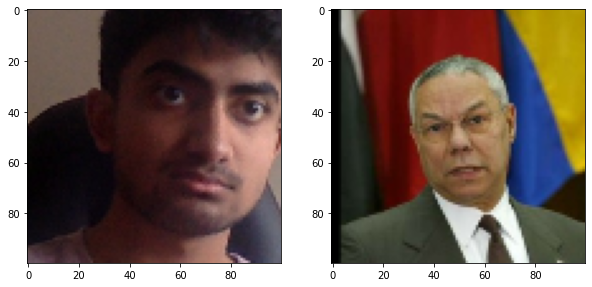

In [115]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(test_input[5])
plt.subplot(1,2,2)
plt.imshow(test_val[5])
plt.show()

In [116]:
siamese_model.save('siamesemodel.h5')

In [118]:
model = tf.keras.models.load_model('siamesemodel.h5',custom_objects={'L1Dist':L1Dist,'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [119]:
model.predict([test_input,test_val])

array([[1.       ],
       [1.       ],
       [1.       ],
       [1.       ],
       [0.9999943],
       [1.       ],
       [0.99996  ],
       [1.       ],
       [1.       ],
       [0.9999939],
       [0.9998993],
       [1.       ],
       [1.       ],
       [1.       ],
       [1.       ],
       [1.       ]], dtype=float32)

# Open CV

In [120]:
def verify(model,detection_threshold,verification_threshold):
    results = []
    for image in os.listdir(os.path.join('application_data','verification_images')):
        input_img = preprocessing(os.path.join('application_data','input_image','input_image.jpg'))
        validation_img = preprocessing(os.path.join('application_data','verification_images',image))
        
        result = model.predict(list(np.expand_dims([input_img,validation_img],axis=1)))
        results.append(result)
        
    detection = np.sum(np.array(results)>detection_threshold)
    
    verification = detection/len(os.listdir(os.path.join('application_data','verification_images')))
    verified = verification > verification_threshold
    
    return results,verified 
    

In [123]:
capture_device = cv2.VideoCapture(0)
while capture_device.isOpened():
    ret, frame = capture_device.read()
    #Making image 250px x 250px
    frame = frame[250:250+250,550:550+250,:]
    #Collecting Anchors
    if cv2.waitKey(10) & 0XFF==ord('v'):
        imgname = os.path.join('application_data','input_data','input_image.jpg')
        cv2.imwrite(imgname,frame)
        results,verified =verify(model,0.9,0.7)
        print(verified)
    
    cv2.imshow('Image Collection',frame)
    # Stop Loop from capturing
    if cv2.waitKey(10) & 0XFF==ord('q'):
        break
# Stop Webcam
capture_device.release()
# Close the image
cv2.destroyAllWindows()